In [6]:
from sklearn.cluster import DBSCAN
from typing import List
import nibabel as nib
import numpy as np
from sklearn.cluster import DBSCAN
from pathlib import Path
import os
from monai.transforms import Resample
from scipy.ndimage import distance_transform_bf
from sklearn.metrics.cluster import normalized_mutual_info_score
import open3d
from collections import defaultdict
from monai.transforms import Spacing
from scipy.ndimage import zoom
from scipy.spatial import distance_matrix
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

In [20]:
from sklearn.metrics import accuracy_score
import numpy as np
def draw_mask_3d(image:np.array):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(np.argwhere(image[0]).T[0],np.argwhere(image[0]).T[1],np.argwhere(image[0]).T[2],s=0.2,alpha=1)

def draw_bounding_box(vertice_points):
    Z=np.array(vertice_points)
    distances = distance_matrix(Z,Z)
    distances_closest = np.argsort(distances,axis=0)
    fig = plt.figure()
    #ax = fig.add_subplot(111, projection='3d')
    ax = Axes3D(fig)
    #r = [-1,1]
    #X, Y = np.meshgrid(r, r)
    #ax.scatter3D(Z[:, 0], Z[:, 1], Z[:, 2])
    verts= [(Z[0],Z[1]),(Z[0],Z[2]),(Z[0],Z[3]),(Z[6],Z[1]),(Z[7],Z[1]),(Z[2],Z[5]),
    (Z[2],Z[7]),(Z[3],Z[5]),(Z[3],Z[6]),(Z[4],Z[7]),(Z[4],Z[6]),(Z[4],Z[5])]

    for element in verts:
        x=[element[0][0],element[1][0]]
        y=[element[0][1],element[1][1]]
        z=[element[0][2],element[1][2]]
        ax.plot(x,y,z,c='r')

def load_nifti(file_path, mask=None, z_factor=None, remove_nan=True, resample_dim=(1.5, 1.5, 1.5)):
    """Load a 3D array from a NIFTI file."""
    nifti = nib.load(file_path)
    struct_arr = nifti.get_fdata()
    #print(struct_arr.shape)
    #values, count = np.unique(struct_arr, return_counts=True)
    #print("Original", count, (count[1]/count[0]))

    if resample_dim is not None:
        struct_arr = np.expand_dims(struct_arr, axis=0)
        ###To Do: Resampling method: Lanczos
        spacing = Spacing(pixdim=resample_dim)
        struct_arr = spacing(struct_arr, nifti.affine)[0]
        struct_arr = np.squeeze(struct_arr, axis=0)
    #print(struct_arr.shape)


    # struct_arr = np.array(nib.load(file_path).get_data().astype("<f4"))  # TODO:
    # nilearn.image.smooth_img(row["path"], fwhm=3).get_data().astype("<f4")
    # struct_arr = nib.load(file_path).get_data().astype("<f4")
    # np.array(nib.load(file_path).get_data().astype("<f4"))
    if remove_nan:
        struct_arr = np.nan_to_num(struct_arr)
    if mask is not None:
        struct_arr *= mask


    return struct_arr

def dbscan(mri_images:List[np.array]):
    new_mri_images=[]
    for image in mri_images:
        db = DBSCAN(eps=1, min_samples=3).fit(np.array(np.where(image==1)).T)
        labels =db.labels_
        empty= np.zeros(image.shape)
        for count,coords in enumerate(np.array(np.where(image==1)).T):
            empty[coords]=labels[count]+1
        new_mri_images.append(empty)
    return mri_images

def remove_border_candidates(mri_images:List[np.array]):
    for image in mri_images:
        borders= image.shape
        for cluster in range(1,int(np.unique(image)[-1])+1):
            coords=np.where(image==cluster)
            if np.any(np.equal(np.amax(coords,axis=1)+1,borders)) or np.min(coords)==0:
                image[image==cluster]=0

    return mri_images


def resample(mri_images:List[np.array],dimension=(256,256,220)):
    new_mri_images=[]
    for image in mri_images:
        shape=image.shape
        zoom_factors= [dimension[0]/shape[0],dimension[1]/shape[1],dimension[2]/shape[2]]
        new_mri_images.append(zoom(image,zoom_factors))
    return new_mri_images

def bounding_boxes(mri_images:List[np.array]):
    bounding_boxes=[]
    for image in mri_images:
        boxes={"candidates":[]}
        for cluster in range(1,int(np.unique(image)[-1]+1)):

            box={}
            indices= open3d.utility.Vector3dVector(np.array(np.where(image==cluster)).T)
            oriented_box=open3d.geometry.OrientedBoundingBox.create_from_points(indices)

            box["position"]=oriented_box.get_center()                   
            box["extent"]= oriented_box.extent
            box["orthogonal_offset_vector"]=oriented_box.R
            box["box_object"]=oriented_box
            box["vertices"]=oriented_box.get_box_points()
            boxes["candidates"].append(box)

        bounding_boxes.append(boxes)
    return bounding_boxes


def evaluate_dbscan(predicted:List[np.array],groundtruth:List[np.array]):
    all_scores=[]
    for pred,truth in zip(predicted,groundtruth):
        clusterscores=defaultdict(list)
        for cluster in range(1,int(np.unique(pred)[-1])+1):
            indices =list(np.array(np.where(pred==cluster)).T)

            for true_cluster in range(1,int(np.unique(truth)[-1])+1):
                true_indices = list(np.array(np.where(truth==true_cluster)).T)

                clusterscores[str(cluster)].append(compare_two_list(true_indices,indices)/len(indices))
 
        all_scores.append(clusterscores)
    return all_scores

def compare_two_list(list_a,list_b):
    list_a= set([tuple(x)for x in list_a])
    list_b= set([tuple(x)for x in list_b])

    return len(list_a.intersection(list_b))


def coverage(boxobject,groundtruth=np.array):
    return len(boxobject.get_point_indices_within_boundinb_box(groundtruth))/len(groundtruth)


/workspace/our-git-project/develop/Leo


Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


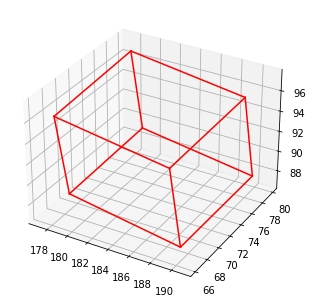

In [23]:

data_path = Path('../../datasets')
print(os.getcwd())
images=[]
images_labeled_masks=[]
for i in range(1,10):
    image_number= f"A00{i}"
    image_orig_path = image_number+'_orig.nii.gz'
    image_vessel_path=image_number+'_vessel.nii.gz'
    image_aneurysm_path =image_number+'_masks.nii.gz'
    image_labeled_masks_path = image_number+'_labeledMasks.nii.gz'
    try:
        images.append(nib.load(data_path/image_aneurysm_path).get_fdata())
        images_labeled_masks.append(nib.load(data_path/image_labeled_masks_path).get_fdata())
    except:
        continue
for i in range(10,20):
    image_number= f"A0{i}"
    image_orig_path = image_number+'_orig.nii.gz'
    image_vessel_path=image_number+'_vessel.nii.gz'
    image_aneurysm_path =image_number+'_masks.nii.gz'
    image_labeled_masks_path = image_number+'_labeledMasks.nii.gz'
    try:
        images.append(nib.load(data_path/image_aneurysm_path).get_fdata())
        images_labeled_masks.append(nib.load(data_path/image_labeled_masks_path).get_fdata())
    except:
        continue


images_masks =dbscan(images)
boxes =bounding_boxes(images_masks)

draw_bounding_box(boxes[7]["candidates"][0]["vertices"])